In [1227]:
# # запускати один раз, потім можна закрити коментами
# !python.exe -m pip install --upgrade pip
# !pip3 install paddlepaddle
# !pip3 install paddleocr

In [1228]:
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np

In [1229]:
# loading the data required for detecting the license plates using cascade classifier.
current_dir = os.getcwd()
plate_cascade_path = os.path.join(current_dir, '../models/haarcascade_ua_license_plate.xml')
plate_cascade = cv2.CascadeClassifier(plate_cascade_path)

In [1230]:
def detect_plate(img, text=""):
    """
    Функція призначена для виявлення та обробки номерних знаків на зображенні.

    Параметри:
    img (numpy.array): Зображення, на якому потрібно виявити та обробити номерні знаки.
    text (str, optional): Текст, який можна додати на зображення навколо номерного знаку.

    Повертає:
    numpy.array: Зображення з виділеними номерними знаками та, за бажанням, доданим текстом.
    numpy.array or None: Зображення області номерного знаку для подальшої обробки або None, якщо номерний знак не був виявлений.
    """
    plate_img = img.copy()  # перша копія зображення
    reg_of_intr = img.copy()  # друга копія зображення

    # виявляє номерні знаки та повертає координати та розміри виявлених контурів номерних знаків
    plate_rect = plate_cascade.detectMultiScale(
        plate_img, scaleFactor=1.4, minNeighbors=7
    )

    # print(f"{plate_rect = }")
    plate_rect = plate_rect[[1]]
    # print(f"{plate_rect = }")

    # виділення частини номерного знака для розпізнавання
    for x, y, w, h in plate_rect:
        plate = reg_of_intr[y : y + h, x : x + w, :]
        # print(f"{plate = }")
        # малювання прямокутника по межі номера
        cv2.rectangle(plate_img, (x + 2, y), (x + w - 3, y + h - 5), (51, 181, 155), 3)

    # Додавання тексту
    if text != "":
        plate_img = cv2.putText(
            plate_img,
            text,
            (x - w // 2, y - h // 2),
            cv2.FONT_HERSHEY_COMPLEX_SMALL,
            0.5,
            (51, 181, 155),
            1,
            cv2.LINE_AA,
        )

    # Повертаємо оброблене зображення з виділеними номерними знаками та область номерного знаку
    return plate_img, plate

In [1231]:
# функція виводу зображень
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

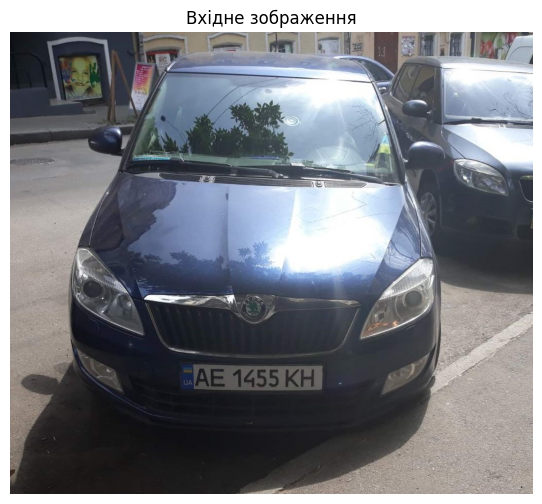

In [1232]:
car_photo = "../images/AE1455KH_f.jpg"
image_path = os.path.join(current_dir, car_photo)
img = cv2.imread(image_path)
display(img, "Вхідне зображення")

In [1233]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img)

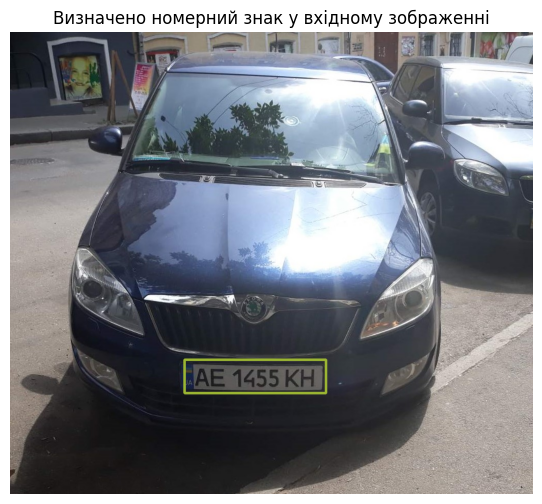

In [1234]:
display(output_img, "Визначено номерний знак у вхідному зображенні")

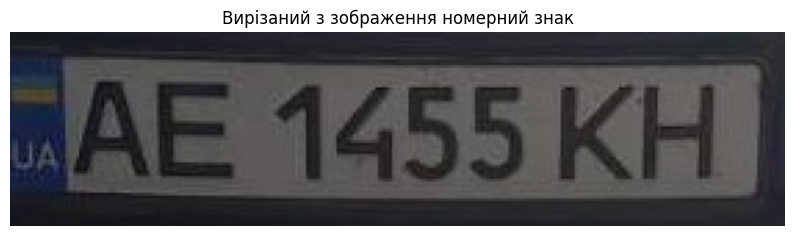

In [1235]:
display(plate, 'Вирізаний з зображення номерний знак')

In [1236]:
def find_contours(dimensions, img) :
    """
    Функція призначена для знаходження контурів символів на зображенні номерного знака.
    
    Параметри:
        dimensions (list): Список, що містить набір розмірів контурів символів: 
                           lower_width, upper_width, lower_height та upper_height.
        img (numpy.ndarray): Вхідне зображення, на якому потрібно знайти контури символів.
        
    Повертає:
        numpy.ndarray: Масив, що містить зображення контурів символів, відсортованих за координатою x.
    """

    # Знайти всі контури на зображенні
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Отримати потенційні розміри
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('../../tmp/contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (76, 202, 102), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

            # print(img_res)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    # plt.axis("off")
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [1237]:
def segment_characters(image):
    """
    Знаходить символи на зображенні номерного знака.

    Параметри:
     - image: Зображення номерного знака, з якого будуть вилучені символи.

    Повертає:
     - char_list: Список контурів символів, знайдених на зображенні.
    """
    # Попередньо оброблюємо зображення номерного знака
    img_lp = cv2.resize(image, (333, 75))  # Resize the image to a fixed size
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Apply binary thresholding
    _, img_binary_lp = cv2.threshold(
        img_gray_lp, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Apply erosion to remove noise
    img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
    # Apply dilation to restore original size
    img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))

    LP_WIDTH = img_binary_lp.shape[0]  # Get the width of the license plate
    LP_HEIGHT = img_binary_lp.shape[1]  # Get the height of the license plate

    # Робимо межі білими
    img_binary_lp[0:3, :] = 255  # Minimum character height
    img_binary_lp[:, 0:3] = 255  # Maximum character height
    img_binary_lp[72:75, :] = 255  # Minimum character width
    img_binary_lp[:, 330:333] = 255  # Maximum character width

    # Приблизні розміри контурів символів обрізаного номерного знака
    dimensions = [LP_WIDTH / 6, LP_WIDTH / 2, LP_HEIGHT / 10, 2 * LP_HEIGHT / 3]
    
    plt.imshow(img_binary_lp, cmap="gray")  # Display the binary image
    # plt.axis("off")
    plt.show()

    # Save the binary image to a file
    cv2.imwrite("../../tmp/contour.jpg", img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)  # Find character contours

    return char_list  # Return the list of character contours

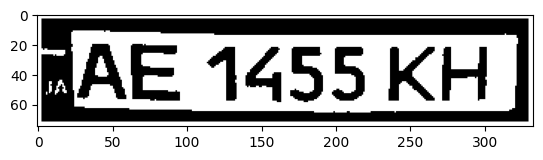

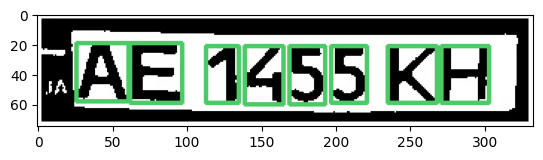

In [1238]:
char = segment_characters(plate)

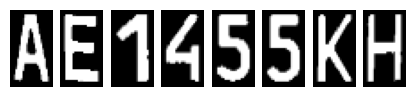

In [1239]:
num_chars_to_display = min(10, len(char))

for i in range(num_chars_to_display):
    plt.subplot(1, 10, i + 1)
    if i < len(char):
        plt.imshow(char[i], cmap="gray")
    plt.axis("off")

## Model Keras for character recognition

In [1240]:
# ! pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

In [1241]:
# load data
train_data_path = os.path.join(current_dir, "../traning_data/train")
val_data_path = os.path.join(current_dir, "../traning_data/val")

# Create ImageDataGenerator for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, width_shift_range=0.05, height_shift_range=0.05
)

train_generator = train_datagen.flow_from_directory(
    train_data_path, target_size=(28, 28), batch_size=32, class_mode="categorical"
)

validation_generator = train_datagen.flow_from_directory(
    val_data_path, target_size=(28, 28), batch_size=32, class_mode="categorical"
)


# Define stop training callback
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc > 0.992:
            self.model.stop_training = True


# Define TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [1242]:
# # Create model
# model_keras = Sequential(
#     [
#         Conv2D(
#             filters=16,
#             kernel_size=(3, 3),
#             input_shape=(28, 28, 3),
#             activation="relu",
#             padding="same",
#         ),
#         MaxPooling2D(pool_size=(2, 2)),
#         Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
#         MaxPooling2D(pool_size=(2, 2)),
#         Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
#         MaxPooling2D(pool_size=(2, 2)),
#         Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same"),
#         MaxPooling2D(pool_size=(2, 2)),
#         Dropout(0.4),
#         Flatten(),
#         Dense(
#             units=36, activation="softmax"
#         ),  # Change units to match the number of classes in your dataset
#     ]
# )

In [1243]:
# Create model
model_keras = Sequential(
    [
        Conv2D(
            filters=16,
            kernel_size=(3, 3),
            input_shape=(28, 28, 3),
            activation="relu",
            padding="same",
        ),
        MaxPooling2D(pool_size=(2, 2)),
        # Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
        # MaxPooling2D(pool_size=(2, 2)),
        # Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
        # MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(
            units=36, activation="softmax"
        ),
    ]
)

In [1244]:
# Compile model
model_keras.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)

# Train the model
batch_size = 1  # 32
callbacks = [tensorboard_callback, stop_training_callback()]
history_keras = model_keras.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=100,
    callbacks=callbacks,
)

Epoch 1/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.0421 - loss: 3.5333 - val_accuracy: 0.0972 - val_loss: 3.3927
Epoch 2/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step - accuracy: 0.2395 - loss: 3.2278 - val_accuracy: 0.3935 - val_loss: 3.0865
Epoch 3/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - accuracy: 0.5045 - loss: 2.8893 - val_accuracy: 0.6389 - val_loss: 2.7240
Epoch 4/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - accuracy: 0.7111 - loss: 2.4668 - val_accuracy: 0.7824 - val_loss: 2.2929
Epoch 5/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step - accuracy: 0.8138 - loss: 2.0110 - val_accuracy: 0.8657 - val_loss: 1.8297
Epoch 6/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - accuracy: 0.8968 - loss: 1.5540 - val_accuracy: 0.8750 - val_loss: 1.4781
Epoch 7/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - accuracy: 0.9122 - loss: 1.1961 - val_accuracy: 0.9352 - val_loss: 1.1392
Epoch 8/100
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - accuracy: 0.9118 - loss: 0.9

In [1245]:
model_keras.summary()

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)              │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_42 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 36)             │       112,932 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,142 (1.30 MB)

 Trainable params: 113,380 (442.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 226,762 (885.79 KB)

In [1246]:
# Evaluate the model on test data
test_loss, test_accuracy = model_keras.evaluate(validation_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9864 - loss: 0.0781
Test Loss: 0.06852588802576065
Test Accuracy: 0.9907407164573669


In [1247]:
def plt_history(
    history, title="Точність та втрати на тренувальному та тестовому наборах"
):
    plt.figure(figsize=(10, 6))

    dict_data = {
        "accuracy": "Точність на тренувальному наборі",
        "val_accuracy": "Точність на тестовому наборі",
        "loss": "Втрати на тренувальному наборі",
        "val_loss": "Втрати на тестовому наборі",
    }

    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    for data_, label_ in dict_data.items():
        plt.plot(
            epochs,
            history.history[data_],
            color=color_loss if (data_[-4:] == "loss") else color_acc,
            linestyle=linestyle_test if (data_[:3] == "val") else linestyle_train,
            label=label_,
        )

    plt.ylim(0, 1)
    plt.title(title)
    plt.xlabel("Епоха")
    plt.ylabel("Метрика")
    plt.grid(True)
    plt.legend()
    plt.show()

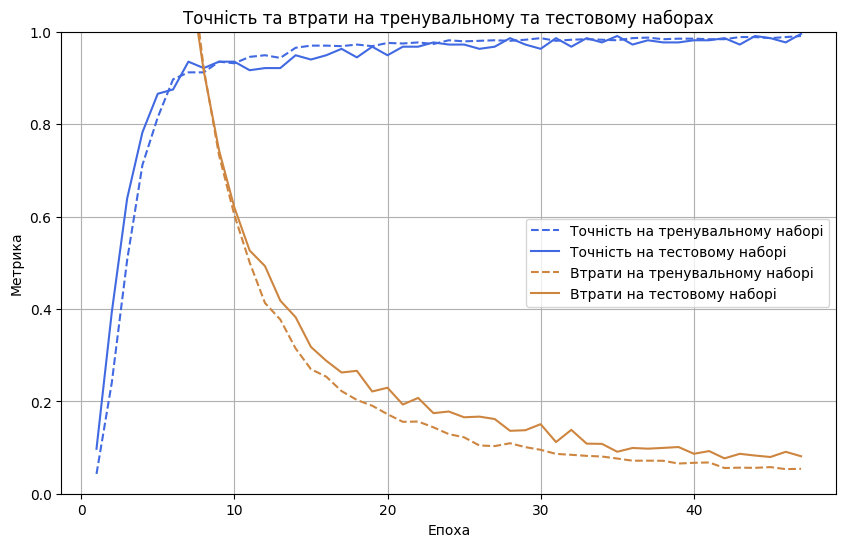

In [1248]:
plt_history(history_keras)

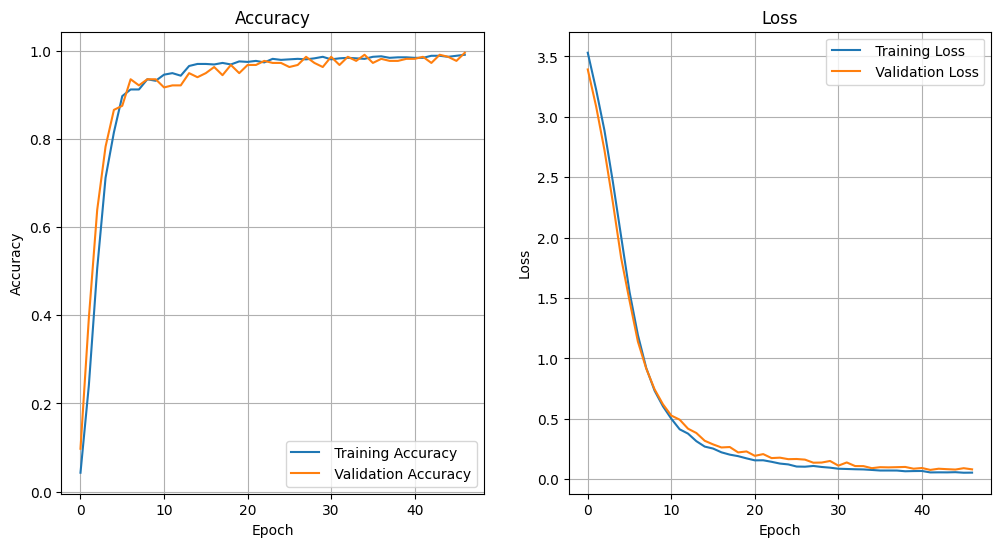

In [1249]:
# Visualization of the training schedule
def plot_training_histories(histories, names):
    plt.figure(figsize=(12, 6))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, names):
        plt.plot(history.history['accuracy'], label=' Training Accuracy')
        plt.plot(history.history['val_accuracy'], label=' Validation Accuracy')

    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plotting loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, names):
        plt.plot(history.history['loss'], label=' Training Loss')
        plt.plot(history.history['val_loss'], label=' Validation Loss')

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

# Call the function to plot the graph
plot_training_histories([history_keras], ['Model Keras'])

In [1250]:
def fix_dimension(img):
    """
    Функція для вирівнювання розмірів зображення до розмірів (28, 28, 3).

    Параметри:
    img (numpy.ndarray): Вхідне зображення з розмірами (n, m), де n та m - цілі числа.

    Повертає:
    numpy.ndarray: Зображення з розмірами (28, 28, 3), де 3 - кількість каналів (RGB).
    """
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img


def show_results(char):
    """
    Функція для показу результатів розпізнавання символів на номерному знаку.

    Параметри:
    char (list): Список зображень символів номерного знаку.

    Повертає:
    str: Рядок, що містить розпізнану номерну знаку, складену з окремих символів.
    """
    dic = {}
    characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    for i, c in enumerate(characters):
        dic[i] = c
    # print(dic)

    output = []
    for i, ch in enumerate(char):  # ітеруємося по символах
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)  # підготовка зображення для моделі
        y_proba = model_keras.predict(img, verbose=0)[
            0
        ]  # отримуємо ймовірності для кожного класу
        y_ = np.argmax(y_proba)  # вибираємо клас з найвищою ймовірністю
        character = dic[y_]  # отримуємо символ, відповідний прогнозованому класу
        output.append(character)  # зберігаємо результат у списку

    plate_number = "".join(output)  # об'єднуємо всі символи у рядок

    return plate_number


print(show_results(char))

AE1455KH


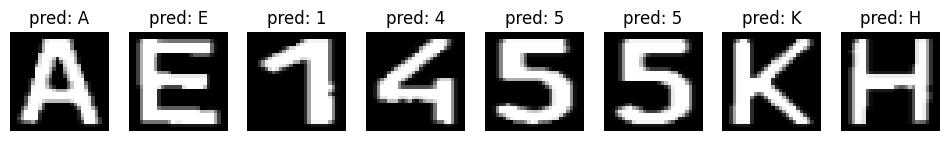

In [1251]:
# Segmented characters and their predicted value.
plt.figure(figsize=(12, 6))
for i, ch in enumerate(char):
    img = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
    plt.subplot(1, 8, i + 1)
    plt.imshow(img, cmap="gray")
    predicted_char = show_results(char)[i]  # prediction before derivation
    plt.title(f"pred: {predicted_char}")  # passing char as an argument
    plt.axis("off")
plt.show()

In [1252]:
def display_result(img_, title="", recognized_text="", font_scale=2, font_thickness=3):
    # Copy the image to avoid modifying the original one
    img = img_.copy()

    # Font settings for OpenCV
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_position = (50, 830)  # Starting position for the text

    # Add recognized text to the image
    cv2.putText(
        img,
        recognized_text,
        text_position,
        font,
        font_scale,
        (0, 255, 0),
        font_thickness,
        cv2.LINE_AA,
    )

    # Convert the image from BGR to RGB for displaying with matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with the title
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

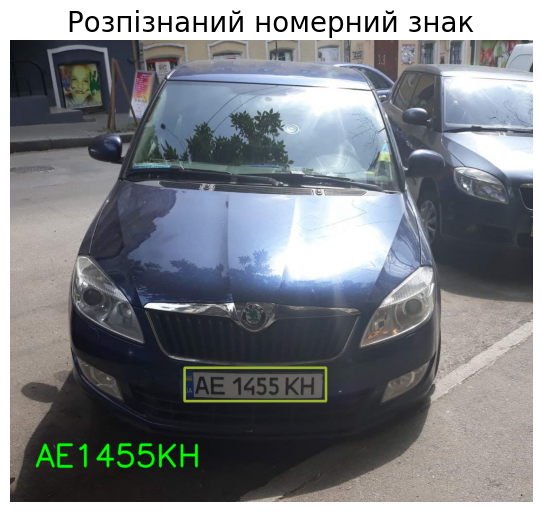

In [1253]:
plate_number = show_results(char)
display_result(
    output_img, title="Розпізнаний номерний знак", recognized_text=plate_number
)

In [1254]:
# Save the model in the format native Keras
model_keras.save("../models/model_ua_license_plate.keras")